# 模型选择 过拟合 欠拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

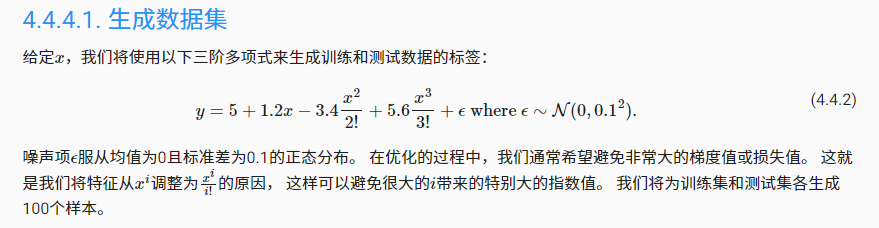

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.9286],
         [-0.6711]]),
 tensor([[ 1.0000e+00, -9.2859e-01,  4.3114e-01, -1.3345e-01,  3.0980e-02,
          -5.7535e-03,  8.9044e-04, -1.1812e-04,  1.3711e-05, -1.4146e-06,
           1.3136e-07, -1.1089e-08,  8.5809e-10, -6.1293e-11,  4.0654e-12,
          -2.5167e-13,  1.4606e-14, -7.9784e-16,  4.1159e-17, -2.0116e-18],
         [ 1.0000e+00, -6.7108e-01,  2.2517e-01, -5.0370e-02,  8.4505e-03,
          -1.1342e-03,  1.2686e-04, -1.2161e-05,  1.0202e-06, -7.6067e-08,
           5.1047e-09, -3.1142e-10,  1.7416e-11, -8.9903e-13,  4.3094e-14,
          -1.9280e-15,  8.0864e-17, -3.1921e-18,  1.1901e-19, -4.2034e-21]]),
 tensor([1.8649, 3.1312]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# 正常

weight: [[ 4.9937005  1.2140467 -3.3932254  5.5591574]]


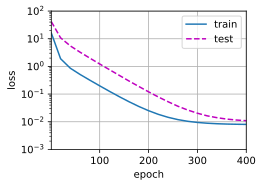

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

# 欠拟合

weight: [[3.529822  3.1560237]]


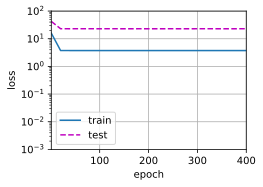

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

# 过拟合

weight: [[ 4.9964128   1.2451067  -3.3649862   5.3166065  -0.2370949   1.010615
   0.14461012  0.06781438  0.17530034 -0.10005748 -0.1256056  -0.11546899
  -0.18489106 -0.10154208  0.16605796 -0.08074649  0.04053712 -0.21025994
  -0.16111183 -0.05701403]]


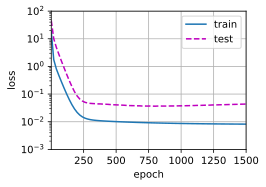

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)